## 与GMM确定模糊阈值

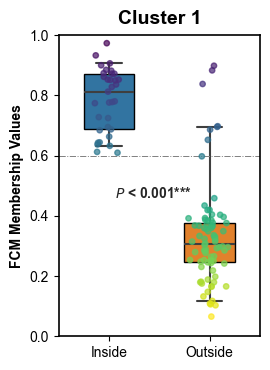

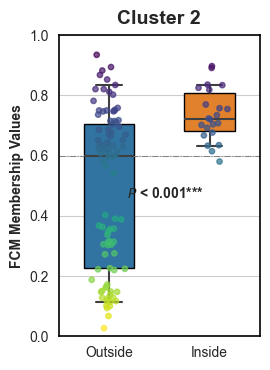


Cluster 0 统计信息：
         count      mean       std       min       25%       50%       75%  \
Group                                                                        
Inside    33.0  0.785046  0.104908  0.609472  0.687039  0.812362  0.871865   
Outside   81.0  0.331800  0.166071  0.065451  0.245582  0.307835  0.377287   

              max  
Group              
Inside   0.973167  
Outside  0.898326  

Cluster 1 统计信息：
         count      mean       std       min       25%       50%       75%  \
Group                                                                        
Inside    22.0  0.735067  0.087209  0.580256  0.680417  0.721926  0.806514   
Outside   92.0  0.489633  0.259886  0.026833  0.225491  0.600209  0.705840   

              max  
Group              
Inside   0.897104  
Outside  0.934549  

总样本数: 114
Inside样本数: 55
Outside样本数: 59
验证总数: 114 (应等于总样本数)

Cluster 0统计：
Inside样本数: 33
Outside样本数: 81

Cluster 1统计：
Inside样本数: 22
Outside样本数: 92


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取Excel文件
df = pd.read_excel('FCM与GMM.xlsx', sheet_name='Sheet1')

# 判断患者是否在交集内
df['Is_Intersection'] = (((df['GMM_Label'] == 0) & (df['FCM_Cluster0'] > df['FCM_Cluster1'])) |
                        ((df['GMM_Label'] == 1) & (df['FCM_Cluster1'] > df['FCM_Cluster0'])) |
                        ((df['FCM_Cluster0'] == 0.50) & (df['FCM_Cluster1'] == 0.50)))

# 准备数据框，分别为cluster 0和1
cluster0_data = []
cluster1_data = []

# 处理cluster 0的数据
# Inside: GMM标签为0且在交集内的样本
cluster0_inside = df[(df['Is_Intersection']) & (df['GMM_Label'] == 0)]['FCM_Cluster0']
# Outside: 所有其他样本的FCM_Cluster0值
cluster0_outside = df[~((df['Is_Intersection']) & (df['GMM_Label'] == 0))]['FCM_Cluster0']

for value in cluster0_inside:
    cluster0_data.append({'Membership': value, 'Group': 'Inside', 'Cluster': 'Cluster 0'})
for value in cluster0_outside:
    cluster0_data.append({'Membership': value, 'Group': 'Outside', 'Cluster': 'Cluster 0'})

# 处理cluster 1的数据
# Inside: GMM标签为1且在交集内的样本
cluster1_inside = df[(df['Is_Intersection']) & (df['GMM_Label'] == 1)]['FCM_Cluster1']
# Outside: 所有其他样本的FCM_Cluster1值
cluster1_outside = df[~((df['Is_Intersection']) & (df['GMM_Label'] == 1))]['FCM_Cluster1']

for value in cluster1_inside:
    cluster1_data.append({'Membership': value, 'Group': 'Inside', 'Cluster': 'Cluster 1'})
for value in cluster1_outside:
    cluster1_data.append({'Membership': value, 'Group': 'Outside', 'Cluster': 'Cluster 1'})

# 转换为DataFrame
cluster0_df = pd.DataFrame(cluster0_data)
cluster1_df = pd.DataFrame(cluster1_data)
# 创建两个子图

# 在绘图之前，先定义显著性检验函数
def add_significance(data, ax, cluster):
    inside_values = data[data['Group'] == 'Inside']['Membership']
    outside_values = data[data['Group'] == 'Outside']['Membership']
    
    # Mann-Whitney U检验
    _, p_value = stats.mannwhitneyu(inside_values, outside_values, alternative='two-sided')
    
    # 根据cluster调整文本位置
    x_pos = 0.47
    if cluster == 1:  # 对于Cluster 1，调整文本位置
        x_pos = 0.53
    
    # 添加显著性标记
    if p_value < 0.001:
        ax.text(x_pos, 0.46, '$P$ < 0.001***', fontsize=10, ha='center', 
                transform=ax.transAxes, fontweight='bold')
    elif p_value < 0.01:
        ax.text(x_pos, 0.46, f'$P$ = {p_value:.3f}**', fontsize=10, ha='center', 
                transform=ax.transAxes, fontweight='bold')
    elif p_value < 0.05:
        ax.text(x_pos, 0.46, f'$P$ = {p_value:.3f}*', fontsize=10, ha='center', 
                transform=ax.transAxes, fontweight='bold')
    else:
        ax.text(x_pos, 0.46, f'$P$ = {p_value:.3f}', fontsize=10, ha='center', 
                transform=ax.transAxes, fontweight='bold')
# 创建第一个图 (Cluster 1)
fig1, ax1 = plt.subplots(figsize=(2.8, 3.8))
plt.style.use('default')
sns.set_style("whitegrid")

# 绘制Cluster 0的箱线图和散点图
norm0 = plt.Normalize(cluster0_df['Membership'].min(), cluster0_df['Membership'].max())
sns.boxplot(x='Group', y='Membership', data=cluster0_df, ax=ax1,
            fliersize=0, whis=[5, 95], width=0.5,
            boxprops=dict(linewidth=1, edgecolor='black'),
            order=['Inside', 'Outside'])

for idx, group in enumerate(['Inside', 'Outside']):
    group_data = cluster0_df[cluster0_df['Group'] == group]
    ax1.scatter(
        x=[idx + np.random.normal(0, 0.08, size=len(group_data))],
        y=group_data['Membership'],
        c=group_data['Membership'],
        cmap='viridis_r',
        norm=norm0,
        s=15,
        alpha=0.7,
        zorder=3
    )

# 设置第一个图的属性
ax1.set_ylim(0.0, 1.0)
ax1.set_title('Cluster 1', fontsize=14, pad=8, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('FCM Membership Values', fontsize=10, fontweight='bold')
ax1.axhline(y=0.60, color='grey', linestyle='-.', linewidth=0.7)

for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

add_significance(cluster0_df, ax1, 0)
plt.tight_layout()
plt.savefig('./image/fcm_boxplot_cluster1.jpg', dpi=1200, bbox_inches='tight')
plt.show()

# 创建第二个图 (Cluster 2)
fig2, ax2 = plt.subplots(figsize=(2.8, 3.8))
plt.style.use('default')
sns.set_style("whitegrid")

# 绘制Cluster 1的箱线图和散点图
norm1 = plt.Normalize(cluster1_df['Membership'].min(), cluster1_df['Membership'].max())
sns.boxplot(x='Group', y='Membership', data=cluster1_df, ax=ax2,
            fliersize=0, whis=[5, 95], width=0.5,
            boxprops=dict(linewidth=1, edgecolor='black'),
            order=['Outside', 'Inside'])

for idx, group in enumerate(['Outside', 'Inside']):
    group_data = cluster1_df[cluster1_df['Group'] == group]
    ax2.scatter(
        x=[idx + np.random.normal(0, 0.08, size=len(group_data))],
        y=group_data['Membership'],
        c=group_data['Membership'],
        cmap='viridis_r',
        norm=norm1,
        s=15,
        alpha=0.7,
        zorder=3
    )

# 设置第二个图的属性
ax2.set_ylim(0.0, 1.0)
ax2.set_title('Cluster 2', fontsize=14, pad=8, fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('FCM Membership Values', fontsize=10, fontweight='bold')
ax2.axhline(y=0.60, color='grey', linestyle='-.', linewidth=0.7)

for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

add_significance(cluster1_df, ax2, 1)
plt.tight_layout()
plt.savefig('./image/fcm_boxplot_cluster2.jpg', dpi=1200, bbox_inches='tight')
plt.show()

# 打印统计信息
print("\nCluster 0 统计信息：")
print(cluster0_df.groupby('Group')['Membership'].describe())
print("\nCluster 1 统计信息：")
print(cluster1_df.groupby('Group')['Membership'].describe())

# 计算各组样本数
total_samples = len(df)
inside_samples = df['Is_Intersection'].sum()
outside_samples = len(df) - inside_samples

print(f"\n总样本数: {total_samples}")
print(f"Inside样本数: {inside_samples}")
print(f"Outside样本数: {outside_samples}")
print(f"验证总数: {inside_samples + outside_samples} (应等于总样本数)")

# 打印每个cluster中inside和outside的样本数
for cluster in [0, 1]:
    print(f"\nCluster {cluster}统计：")
    cluster_inside = len(df[(df['Is_Intersection']) & (df['GMM_Label'] == cluster)])
    cluster_outside = len(df) - cluster_inside  # 修改这里，outside为总数减去inside
    print(f"Inside样本数: {cluster_inside}")
    print(f"Outside样本数: {cluster_outside}")

基于FCM和GMM确认的inside 人数: 55人
基于FCM和GMM确认的outside 人数: 59人
Counts and proportions of FCM labels within the intersection:
FCM Label 0: 33 (60.00%)
FCM Label 1: 22 (40.00%)
Counts and proportions of FCM labels outside the intersection:
FCM Label 0: 8 (13.56%)
FCM Label 1: 51 (86.44%)


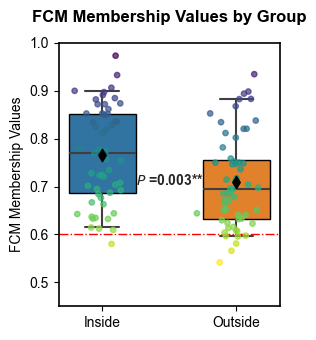


统计信息：
         count      mean       std       min       25%       50%       75%  \
Group                                                                        
Inside    55.0  0.765054  0.100449  0.580256  0.685619  0.769640  0.851912   
Outside   59.0  0.709290  0.096336  0.541522  0.632495  0.695347  0.755302   

              max  
Group              
Inside   0.973167  
Outside  0.934549  

T检验结果:
统计量: 3.021, p值: 0.003
Mann-Whitney U检验结果:
统计量: 2133.000, p值: 0.004
通过t检验，组间存在显著差异。
通过Mann-Whitney U检验，组间存在显著差异。


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 读取Excel文件
df = pd.read_excel('FCM与GMM.xlsx', sheet_name='Sheet1')

# 获取每个患者在其GMM分配的簇中的FCM membership值
df['FCM_Membership'] = np.where(
    df['GMM_Label'] == 0,
    df['FCM_Cluster0'],
    df['FCM_Cluster1']
)

# 判断患者是否在交集内
df['Is_Intersection'] = (((df['GMM_Label'] == 0) & (df['FCM_Cluster0'] > df['FCM_Cluster1'])) |
                         ((df['GMM_Label'] == 1) & (df['FCM_Cluster1'] > df['FCM_Cluster0'])) |
                         ((df['FCM_Cluster0'] == 0.50) & (df['FCM_Cluster1'] == 0.50)))

# 对于 outside 群体，获取相对立的 GMM 簇的 FCM membership 值
df['FCM_Membership_Outside'] = np.where(
    ~df['Is_Intersection'],
    np.where(df['GMM_Label'] == 0, df['FCM_Cluster1'], df['FCM_Cluster0']),
    df['FCM_Membership']
)

# 准备数据 - 交集内和非交集的 membership 值
intersection_values = df[df['Is_Intersection']]['FCM_Membership']
non_intersection_values = df[~df['Is_Intersection']]['FCM_Membership_Outside']

# 计算并打印交集内外的患者数量
intersection_count = df['Is_Intersection'].sum()
non_intersection_count = (~df['Is_Intersection']).sum()

# 交集内 FCM Label 的 0 和 1 人数计算
intersection_label_counts = df[df['Is_Intersection']]['FCM label'].value_counts()

# 计算交集内每个 FCM Label 的比例
label0_proportion = intersection_label_counts.get(0, 0) / intersection_count
label1_proportion = intersection_label_counts.get(1, 0) / intersection_count

# 打印交集内和交集外的人数
print(f"基于FCM和GMM确认的inside 人数: {intersection_count}人")
print(f"基于FCM和GMM确认的outside 人数: {non_intersection_count}人")

# 打印交集内的FCM Label为0和1的人数以及比例
print("Counts and proportions of FCM labels within the intersection:")
print(f"FCM Label 0: {intersection_label_counts.get(0, 0)} ({label0_proportion:.2%})")
print(f"FCM Label 1: {intersection_label_counts.get(1, 0)} ({label1_proportion:.2%})")

# 交集外 FCM Label 的 0 和 1 人数计算
outside_label_counts = df[~df['Is_Intersection']]['FCM label'].value_counts()

# 计算交集外每个 FCM Label 的比例
outside_label0_proportion = outside_label_counts.get(0, 0) / non_intersection_count
outside_label1_proportion = outside_label_counts.get(1, 0) / non_intersection_count

# 打印交集外的 FCM Label 为 0 和 1 的人数以及比例
print("Counts and proportions of FCM labels outside the intersection:")
print(f"FCM Label 0: {outside_label_counts.get(0, 0)} ({outside_label0_proportion:.2%})")
print(f"FCM Label 1: {outside_label_counts.get(1, 0)} ({outside_label1_proportion:.2%})")

# 保存 inside 和 outside 每个被试的 membership value 为 Excel
inside_values = df[df['Is_Intersection']][['FCM_Membership']]
outside_values = df[~df['Is_Intersection']][['FCM_Membership_Outside']]

inside_values['Group'] = 'Inside'
outside_values['Group'] = 'Outside'

# 合并并保存到 Excel
membership_values = pd.concat([inside_values, outside_values.rename(columns={'FCM_Membership_Outside': 'FCM_Membership'})])
membership_values.to_excel('inside_outside_membership_values.xlsx', index=False)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# 读取Excel文件
df = pd.read_excel('./inside_outside_membership_values.xlsx')

# 设置图形风格和大小
plt.style.use('default')
# 回到原来的图形大小，因为不需要为颜色条预留空间了
fig, ax = plt.subplots(figsize=(3, 3.5))

# 设置seaborn样式
sns.set_style("whitegrid")

# 创建颜色映射对象
norm = plt.Normalize(df['FCM_Membership'].min(), df['FCM_Membership'].max())

# 创建箱线图
sns.boxplot(x='Group', y='FCM_Membership', data=df, fliersize=0, whis=[5, 95], width=0.5,
            boxprops=dict(linewidth=1, edgecolor='black'), ax=ax)

# 为每个组分别绘制散点
for idx, group in enumerate(['Inside', 'Outside']):
    group_data = df[df['Group'] == group]
    
    # 添加带有颜色映射的散点
    ax.scatter(
        x=[idx + np.random.normal(0, 0.08, size=len(group_data))],  # 添加随机抖动
        y=group_data['FCM_Membership'],
        c=group_data['FCM_Membership'],
        cmap='viridis_r',
        norm=norm,
        
        s=15,               # 散点大小
        alpha=0.7,         # 散点透明度
        zorder=3           # 确保散点在箱线图上方
    )

# 设置Y轴范围
ax.set_ylim(0.45, 1.0)

# 设置整个图的外边框宽度和颜色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# 设置图形标题和标签
ax.set_title('FCM Membership Values by Group', fontsize=12, pad=15, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('FCM Membership Values', fontsize=10)

# 添加显著性标记
ax.text(0.5, 0.46, '$P$ =0.003**', fontsize=10, ha='center', transform=ax.transAxes, fontweight='bold')

# 计算并添加均值标记
mean_inside = df[df['Group'] == 'Inside']['FCM_Membership'].mean()
mean_outside = df[df['Group'] == 'Outside']['FCM_Membership'].mean()
ax.scatter(x=['Inside', 'Outside'], y=[mean_inside, mean_outside], 
          color='black', s=40, zorder=5, marker='d')

# 添加阈值线
ax.axhline(y=0.60, color='red', linestyle='-.', linewidth=1, label='Threshold = 0.60')

# 调整布局
plt.tight_layout()

# 保存图形
plt.savefig('fcm_boxplot_with_colormapped_points.jpg', dpi=1200, bbox_inches='tight')

# 显示图形
plt.show()
# 打印每个组的基本统计信息
print("\n统计信息：")
print(df.groupby('Group')['FCM_Membership'].describe())

# 检验组间差异
inside_values = df[df['Group'] == 'Inside']['FCM_Membership']
outside_values = df[df['Group'] == 'Outside']['FCM_Membership']

# 进行 t 检验
t_stat, p_value_t = stats.ttest_ind(inside_values, outside_values, equal_var=False)

# 进行 Mann-Whitney U 检验
u_stat, p_value_u = stats.mannwhitneyu(inside_values, outside_values, alternative='two-sided')

# 打印检验结果
print(f"\nT检验结果:\n统计量: {t_stat:.3f}, p值: {p_value_t:.3f}")
print(f"Mann-Whitney U检验结果:\n统计量: {u_stat:.3f}, p值: {p_value_u:.3f}")

# 判断显著性
alpha = 0.05
if p_value_t < alpha:
    print("通过t检验，组间存在显著差异。")
else:
    print("通过t检验，组间不存在显著差异。")

if p_value_u < alpha:
    print("通过Mann-Whitney U检验，组间存在显著差异。")
else:
    print("通过Mann-Whitney U检验，组间不存在显著差异。")

 Threshold Inside_Count Outside_Count Inside_Membership_Mean_Std Outside_Membership_Mean_Std Membership_Difference Cluster0_Count Cluster1_Count Mixed_Count Membership_Difference_Test
      0.55           55            59                0.77 ± 0.10                 0.29 ± 0.10                  0.47             41             72           1           t=25.70, p=0.000
      0.60           54            60                0.77 ± 0.10                 0.30 ± 0.10                  0.47             40             67           7           t=25.15, p=0.000
      0.65           45            69                0.80 ± 0.08                 0.34 ± 0.15                  0.46             34             51          29           t=21.13, p=0.000
      0.70           38            76                0.82 ± 0.07                 0.37 ± 0.17                  0.45             26             39          49           t=19.53, p=0.000
      0.75           30            84                0.84 ± 0.05                

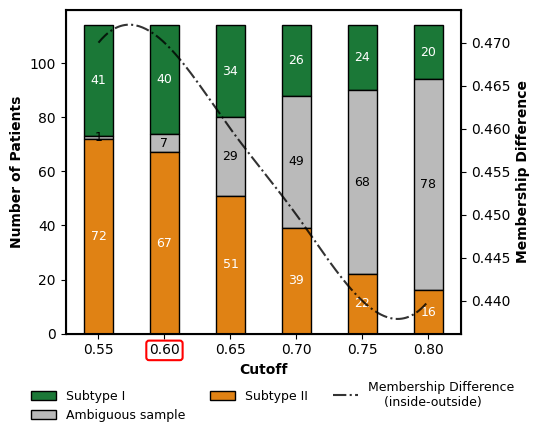

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.interpolate import make_interp_spline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 读取Excel文件
df = pd.read_excel('FCM与GMM.xlsx', sheet_name='Sheet1')

# 定义阈值范围
thresholds = np.arange(0.55, 0.85, 0.05)

# 创建一个空的DataFrame来存储结果
results_df = pd.DataFrame(columns=[
    'Threshold', 'Inside_Count', 'Outside_Count',
    'Inside_Membership_Mean_Std', 'Outside_Membership_Mean_Std',
    'Membership_Difference', 'Cluster0_Count', 'Cluster1_Count',
    'Mixed_Count', 'Membership_Difference_Test'
])

for threshold in thresholds:
    # 判断每个被试在GMM和FCM中是否被分到了相同的簇
    df['Same_Cluster'] = (
        ((df['GMM_Label'] == 0) & (df['FCM_Cluster0'] > df['FCM_Cluster1'])) |
        ((df['GMM_Label'] == 1) & (df['FCM_Cluster1'] > df['FCM_Cluster0']))
    )

    # 判断每个被试对应簇的FCM隶属度是否高于阈值
    df['High_Membership'] = (
        ((df['GMM_Label'] == 0) & (df['FCM_Cluster0'] > threshold)) |
        ((df['GMM_Label'] == 1) & (df['FCM_Cluster1'] > threshold))
    )

    # 判断每个被试是否是"Inside"患者
    df['Inside'] = df['Same_Cluster'] & df['High_Membership']

    # 计算Inside和Outside的人数
    inside_count = df['Inside'].sum()
    outside_count = len(df) - inside_count

    # 计算Inside和Outside的隶属度均值和标准差
    inside_membership = df[df['Inside']].apply(
        lambda row: row['FCM_Cluster0'] if row['GMM_Label'] == 0 else row['FCM_Cluster1'],
        axis=1
    )
    outside_membership = df[~df['Inside']].apply(
        lambda row: row['FCM_Cluster0'] if row['GMM_Label'] == 0 else row['FCM_Cluster1'],
        axis=1
    )

    inside_membership_mean = inside_membership.mean()
    inside_membership_std = inside_membership.std()
    outside_membership_mean = outside_membership.mean()
    outside_membership_std = outside_membership.std()

    # 进行差异检验
    if len(inside_membership) > 1 and len(outside_membership) > 1:
        t_stat, p_value = stats.ttest_ind(
            inside_membership, outside_membership, equal_var=False
        )
        membership_difference_test = f"t={t_stat:.2f}, p={p_value:.3f}"
    else:
        membership_difference_test = "Insufficient data"

    # 计算Inside和Outside隶属度均值的差值
    membership_difference = inside_membership_mean - outside_membership_mean

    # 计算Cluster0, Cluster1和Mixed的人数
    df['Cluster0'] = df['FCM_Cluster0'] >= threshold
    df['Cluster1'] = df['FCM_Cluster1'] >= threshold
    df['Mixed'] = ~(df['Cluster0'] | df['Cluster1'])

    cluster0_count = df['Cluster0'].sum()
    cluster1_count = df['Cluster1'].sum()
    mixed_count = df['Mixed'].sum()

    # 创建一个临时的DataFrame来存储当前阈值的结果
    temp_df = pd.DataFrame({
        'Threshold': [threshold],
        'Inside_Count': [inside_count],
        'Outside_Count': [outside_count],
        'Inside_Membership_Mean_Std': [
            f"{inside_membership_mean:.2f} ± {inside_membership_std:.2f}"
        ],
        'Outside_Membership_Mean_Std': [
            f"{outside_membership_mean:.2f} ± {outside_membership_std:.2f}"
        ],
        'Membership_Difference': [f"{membership_difference:.2f}"],
        'Cluster0_Count': [cluster0_count],
        'Cluster1_Count': [cluster1_count],
        'Mixed_Count': [mixed_count],
        'Membership_Difference_Test': [membership_difference_test]
    })

    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# 打印结果并保存到Excel
print(results_df.to_string(index=False))
results_df.to_excel('./table/threshold_results.xlsx', index=False)
print("Threshold results saved to 'threshold_results.xlsx'")

# 提取绘图所需的数据
bar_width = 0.45
thresholds = results_df['Threshold']
subtype_I_counts = results_df['Cluster0_Count']
subtype_II_counts = results_df['Cluster1_Count']
mixed_counts = results_df['Mixed_Count']
membership_differences = results_df['Membership_Difference'].astype(float)

# 设置柱状图的位置 
r1 = np.arange(len(thresholds))

fig, ax1 = plt.subplots(figsize=(5.5, 4.5))

# 关闭任何grid
ax1.grid(False)

# 创建堆叠柱状图
bars3 = ax1.bar(
    r1, subtype_I_counts,
    bottom=subtype_II_counts + mixed_counts,
    color='#1b7837', width=bar_width,
    edgecolor='black', label='Subtype I'
)
bars2 = ax1.bar(
    r1, mixed_counts,
    bottom=subtype_II_counts,
    color='#bababa', width=bar_width,
    edgecolor='black', label='Ambiguous sample'
)
bars1 = ax1.bar(
    r1, subtype_II_counts,
    color='#e08214', width=bar_width,
    edgecolor='black', label='Subtype II'
)

# 在柱子上添加样本数量
for i in range(len(r1)):
    ax1.text(
        r1[i], subtype_II_counts[i] / 2,
        f'{subtype_II_counts[i]}', ha='center',
        va='center', color='white', fontsize=9
    )
    ax1.text(
        r1[i], subtype_II_counts[i] + mixed_counts[i] / 2,
        f'{mixed_counts[i]}', ha='center',
        va='center', color='black', fontsize=9
    )
    ax1.text(
        r1[i],
        subtype_II_counts[i] + mixed_counts[i] + subtype_I_counts[i] / 2,
        f'{subtype_I_counts[i]}', ha='center',
        va='center', color='white', fontsize=9
    )

# 设置标签和标题    
ax1.set_xlabel('Cutoff', fontsize=10, fontweight='bold')
ax1.set_ylabel('Number of Patients', fontsize=10, fontweight='bold')
ax1.set_xticks(r1)
ax1.set_xticklabels([f'{th:.2f}' for th in thresholds])

# 为0.60刻度添加红色方框
for label in ax1.get_xticklabels():
    if label.get_text() == '0.60':
        label.set_bbox({
            'facecolor': 'none',
            'edgecolor': 'red',
            'boxstyle': 'round,pad=0.2',
            'linewidth': 1.5
        })

# 设置外边框四条线条为黑色加粗
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

# 创建第二个y轴
ax2 = ax1.twinx()
ax2.grid(False)

# 平滑membership difference曲线
xnew = np.linspace(r1.min(), r1.max(), 300)
spl = make_interp_spline(r1, membership_differences, k=3)
membership_smooth = spl(xnew)

ax2.plot(
    xnew, membership_smooth,
    color='black', linewidth=1.5,
    label='Membership Difference\n    (inside-outside)',
    alpha=0.8, linestyle='-.'
)
ax2.set_ylabel(
    'Membership Difference',
    fontsize=10, fontweight='bold', color='black'
)
ax2.tick_params(axis='y', colors='black', labelcolor='black')

# 合并图例 
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left',
    bbox_to_anchor=(-0.1, -0.13),
    borderaxespad=0.,
    prop={'size': 9},
    ncols=3,
    frameon=False
)

fig.tight_layout()

# 保存和展示图表
plt.savefig(
    './image/FCM_kmeans_Intersection_BarChart_with_SmoothLine.jpg',
    dpi=600, bbox_inches='tight'
)
plt.show()